# Setup
---

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt

from preprocess import preprocess_all
from util import read_bills, read_stopwords, split_ttf
from variants import variant_i, variant_ii, variant_iii, variant_iv

from fasttext import prepare_files

In [3]:
warnings.filterwarnings('ignore')

In [4]:
bills = read_bills('../lab1/data')

In [5]:
stopwords = read_stopwords('./stopwords-pl.txt')

In [6]:
df = preprocess_all(bills)

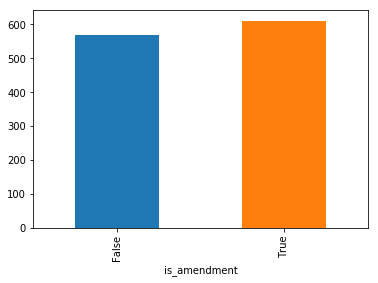

In [7]:
df.groupby(by='is_amendment').count()['text'].plot.bar();

In [8]:
train, test, validation = split_ttf(df)

In [9]:
print('train      {}'.format(len(train)))
print('test       {}'.format(len(test)))
print('validation {}'.format(len(validation)))

train      707
test       236
validation 236


In [10]:
variants = [
    ('i', variant_i),
    ('ii', variant_ii),
    ('iii', variant_iii),
    ('iv', variant_iv)
]

In [11]:
variant_dfs = {}

for name, variant in variants:
    v_train = variant(train)
    v_validation = variant(validation)
    v_test = variant(test)

    variant_dfs[name] = (v_train, v_validation, v_test)

    prepare_files(v_train, 'fast/{}_train.csv'.format(name))
    prepare_files(v_validation, 'fast/{}_validation.csv'.format(name))
    prepare_files(v_test, 'fast/{}_test.csv'.format(name))

# SVM + TF-IDF
---

### Classifier

In [61]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from preprocess import extract_tokens
from util import build_vocabulary
from svm import teach_svm, evaluate, svm_show_scores, teach_progressive_svm
from vis import plot_metrics_for

In [62]:
results = {}

for name, (v_train, v_validation, v_test) in variant_dfs.items():
    v_df = pd.concat([v_train, v_validation, v_test])
    result = teach_svm(v_train, v_validation, v_df, stopwords)
    results[name] = result

Score 0.32395993836671805 for tol=1e-11, c=0.1, kernel=rbf, drop=0
Score 0.8347309270679746 for tol=1e-11, c=100, kernel=rbf, drop=1000
Score 0.32395993836671805 for tol=1e-11, c=0.1, kernel=rbf, drop=0
Score 0.5488033479565638 for tol=1e-11, c=1, kernel=rbf, drop=1000
Score 0.32395993836671805 for tol=1e-11, c=0.1, kernel=rbf, drop=0
Score 0.4887540476676682 for tol=1e-11, c=200, kernel=rbf, drop=0
Score 0.5040241502635402 for tol=1, c=200, kernel=rbf, drop=0
Score 0.32395993836671805 for tol=1e-11, c=0.1, kernel=rbf, drop=0
Score 0.36930591510770283 for tol=1e-11, c=100, kernel=rbf, drop=0
Score 0.37800389088720626 for tol=1e-11, c=200, kernel=rbf, drop=0
Score 0.4304738274461153 for tol=1, c=200, kernel=rbf, drop=0


In [63]:
for name, result in results.items():
    clf, vocab, clf_metrics, metrics = result
    v_test = variant_dfs[name][2]
    
    print('variant: {}'.format(name))
    print(clf_metrics)
    svm_show_scores(clf, v_test, vocab, stopwords)
    print('-----------------------------')

variant: i
(1e-11, 100, 0.8347309270679746, 'rbf', 1000)
Precision: 0.8614749186783085
Recall:    0.8601694915254238
F1 score:  0.8604352087164442
-----------------------------
variant: ii
(1e-11, 1, 0.5488033479565638, 'rbf', 1000)
Precision: 0.5707460950481887
Recall:    0.5550847457627118
F1 score:  0.5543896530639016
-----------------------------
variant: iii
(1, 200, 0.5040241502635402, 'rbf', 0)
Precision: 0.7979060391640613
Recall:    0.6822033898305084
F1 score:  0.629289677949337
-----------------------------
variant: iv
(1, 200, 0.4304738274461153, 'rbf', 0)
Precision: 0.6908338910210009
Recall:    0.6016949152542372
F1 score:  0.5081165403088159
-----------------------------


### Parameters

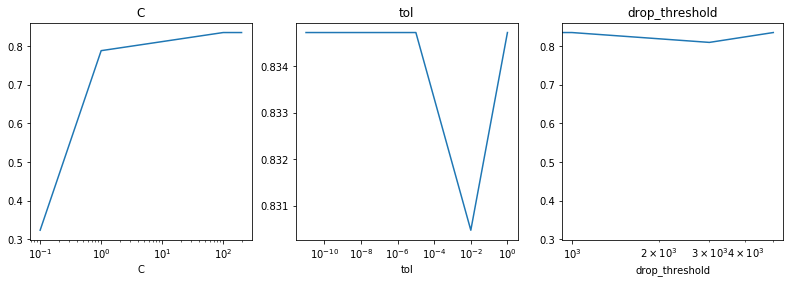

In [86]:
_, _, _, metrics = results['i']
plot_metrics_for(metrics)

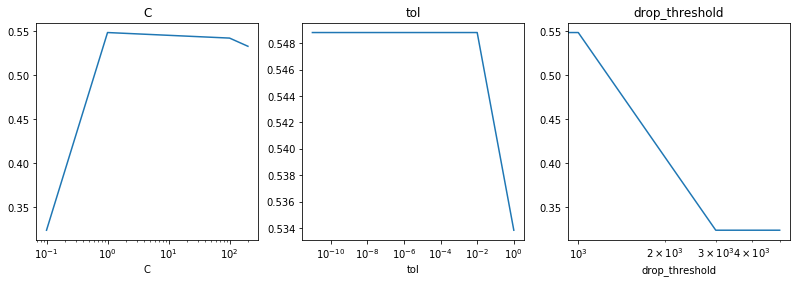

In [87]:
_, _, _, metrics = results['ii']
plot_metrics_for(metrics)

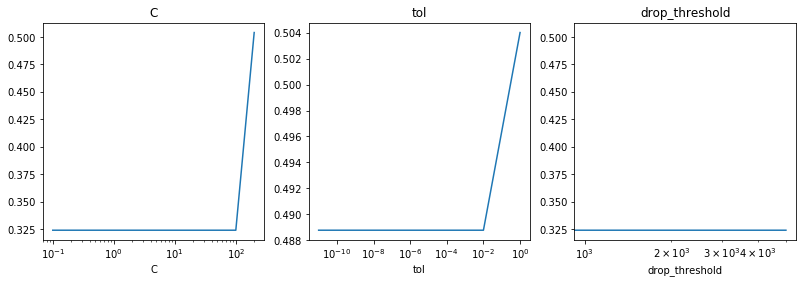

In [88]:
_, _, _, metrics = results['iii']
plot_metrics_for(metrics)

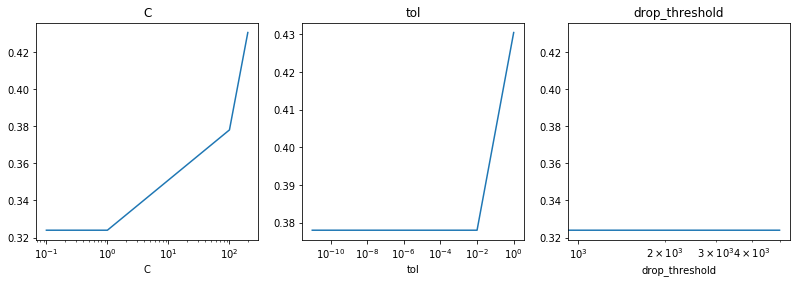

In [89]:
_, _, _, metrics = results['iv']
plot_metrics_for(metrics)

### Number of samples to score

In [35]:
v_train, v_validation, v_test = variant_dfs['i']

results = teach_progressive_svm(
    v_train,
    v_validation,
    v_test,
    stopwords,
    tol=1e-11,
    C=100,
    drop_threshold=1000)

In [48]:
result_df = pd.DataFrame(list(results.values()), columns=['size', 'validation_score', 'test_score'])

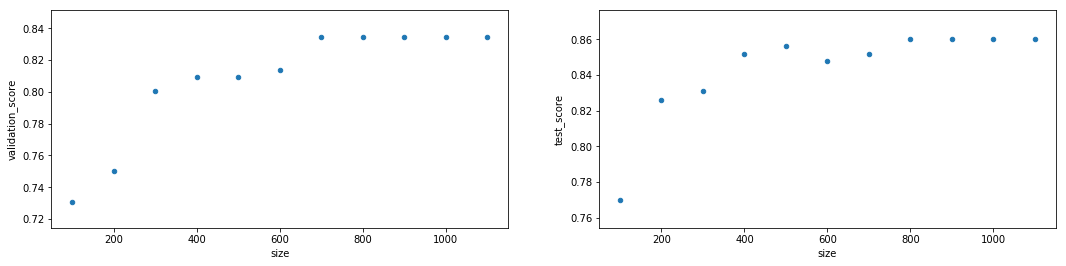

In [58]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,4))

result_df.plot(x='size', y='validation_score', kind='scatter', ax=ax1)
result_df.plot(x='size', y='test_score', kind='scatter', ax=ax2)

plt.show()

# Fasttext
---

In [46]:
import fastText

from fasttext import prepare_files, teach_fasttext, fasttext_show_scores

In [51]:
fasttext_results = {}
for name, (v_train, v_validation, v_test) in variant_dfs.items():
    print('Training classifier: {}'.format(name))
    clf, metrics = teach_fasttext('fast/{}_train.csv'.format(name), v_validation)
    fasttext_results[name] = (clf, metrics)
    print('------------------------------------')

Training classifier: i
Score 0.5101728419434874 for lr=0.1, wordNgrams=1
Score 0.517155849524597 for lr=0.1, wordNgrams=2
Score 0.8261307579121772 for lr=0.6, wordNgrams=1
Score 0.8598753232346475 for lr=1.1, wordNgrams=1
Score 0.8727443254139844 for lr=1.6, wordNgrams=1
Score 0.8811511969699186 for lr=1.6, wordNgrams=2
Score 0.8855007430153361 for lr=2.1, wordNgrams=2
Score 0.8855500766542294 for lr=2.6, wordNgrams=2
Score 0.8939212158482054 for lr=3.1, wordNgrams=2
Score 0.8982466393921683 for lr=3.6, wordNgrams=2
------------------------------------
Training classifier: ii
Score 0.4830793058902056 for lr=0.1, wordNgrams=1
Score 0.4960955773867357 for lr=0.1, wordNgrams=2
Score 0.6507918410478164 for lr=0.6, wordNgrams=1
Score 0.6781405782652042 for lr=0.6, wordNgrams=2
Score 0.6826178937787508 for lr=1.1, wordNgrams=1
Score 0.6841982180310185 for lr=1.1, wordNgrams=2
Score 0.69918488808384 for lr=1.6, wordNgrams=1
Score 0.7061249594764588 for lr=1.6, wordNgrams=2
Score 0.71086854643

In [52]:
for name, (clf, _) in fasttext_results.items():
    print("variant: {}".format(name))
    _, _, test = variant_dfs[name]
    fasttext_show_scores(clf, test)
    print('-----------------------------')

variant: i
Precision: 0.8939961874283908
Recall:    0.8940677966101694
F1 score:  0.8940157623079241
-----------------------------
variant: ii
Precision: 0.7516233766233766
Recall:    0.75
F1 score:  0.7504750701294001
-----------------------------
variant: iii
Precision: 0.759167385677308
Recall:    0.75
F1 score:  0.7506877640924212
-----------------------------
variant: iv
Precision: 0.632029273335691
Recall:    0.6016949152542372
F1 score:  0.5968669748330766
-----------------------------


# Flair 
---

[GoogleColab Jupyter Notebook](https://colab.research.google.com/drive/1Jeg72iqFkGkr9FHwIpYCS2Ps9aw9vpT6#scrollTo=byVout5-o4yI)